In [1]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

In [2]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

Using TensorFlow backend.


In [3]:
# Getting data

google = web.DataReader("GOOG", "yahoo")

In [4]:
scaler = MinMaxScaler()

In [5]:
# Scaling and reshaping the trainig data
# X -> t, y -> t+1

training_data = google['2012-01-03':'2016-12-31']
training_data = training_data.iloc[:, 1:2].values
scaled_training_data = scaler.fit_transform(training_data)
X_train = scaled_training_data[:-1]
X_train = np.reshape(X_train, (X_train.shape[0], 1, 1))
y_train = scaled_training_data[1:]

In [6]:
# Scaling and reshaping training data
testing_data = google['2017-01-04':]
testing_data = testing_data.iloc[:, 1:2].values
X_test = testing_data[:-1]
X_test_scaled = scaler.transform(X_test)
X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, 1))
y_test = testing_data[1:]

In [7]:
# Building the model

def build_model():
    model = Sequential()
    model.add(LSTM(15, activation='sigmoid', input_shape = (None, 1)))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    return model

In [8]:
# Training the model and making prediction
model = build_model()

model.fit(X_train, y_train, batch_size=32, epochs=300, verbose=0)

inputs = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, 1))

y_hat = model.predict(inputs)

y_hat = scaler.inverse_transform(y_hat)

In [9]:
from sklearn.metrics import r2_score, mean_squared_error

In [10]:
print("R^2:", r2_score(y_test, y_hat))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_hat)))

R^2: 0.979442521362
RMSE: 8.52086749794


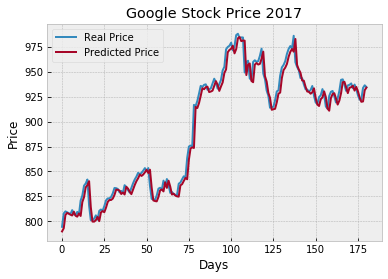

In [11]:
plt.plot(y_test, label='Real Price')
plt.plot(y_hat, label='Predicted Price')
plt.title('Google Stock Price 2017')
plt.xlabel('Days')
plt.ylabel("Price")
plt.legend()
plt.show()

### Window method

In [12]:
# reshape Open price such that:
# t-4, t-3, t-2, t-1, t  --> predict t+1

In [13]:
g = google['2012-01-03':'2016-12-31']['Open'].values

In [14]:
window = 5

def reshape_data(array_1d, window):
    window_ = window + 1
    data = np.array([array_1d[i: array_1d.size - (window_ -i)] for i in range(window_)])
    columns = ["X_t+{}".format(str(i+1)) for i in range(window_-1)]
    columns.append('y')
    return pd.DataFrame(data.T, columns=columns)

In [15]:
new_train_df = reshape_data(g, window)

new_scaled_df = scaler.transform(new_train_df)

X_train_scaled = new_scaled_df[:, :-1]
y_train_scaled = new_scaled_df[:, -1]

In [16]:
X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, window))

In [17]:
test_data = google['2017-01-04':]['Open'].values
new_test_df = reshape_data(test_data, window)

In [18]:
X_test_scaled = scaler.transform(new_test_df.iloc[:, :-1])
y_test = new_test_df.iloc[:, -1].values

In [19]:
def build_model_2():
    model = Sequential()
    model.add(LSTM(15, activation='sigmoid', input_shape = (None, window)))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    return model

In [20]:
model_2 = build_model_2()

model_2.fit(X_train_reshaped, y_train_scaled, batch_size=32, epochs=300, verbose=0)

inputs_2 = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, window))

y_hat_2 = model_2.predict(inputs_2)

y_hat_2 = scaler.inverse_transform(y_hat_2)

In [21]:
print("R^2:", r2_score(y_test, y_hat_2))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_hat_2)))

R^2: 0.973500866835
RMSE: 9.43048657699


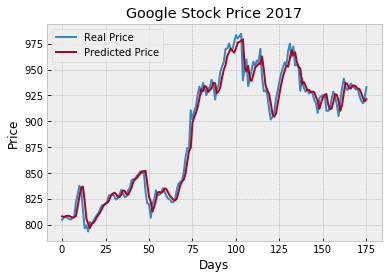

In [22]:
plt.plot(y_test, label='Real Price')
plt.plot(y_hat_2, label='Predicted Price')
plt.title('Google Stock Price 2017')
plt.xlabel('Days')
plt.ylabel("Price")
plt.legend()
plt.show()